### The objective is to simulate ultrasonic signal propagation in a pipe and estimate sensor locations using time of arrival data 

Inspired from the paper "Self-adaptation of ultrasound sensing networks"
URL: "https://www.sciencedirect.com/science/article/pii/S0888327024011130" 

#### As inputs, we have the following:
1) Pipe structure with known diameter and material properties
2) Sensor location (initially known but estimated later)
3) Simulated time of arrival data for signals travelling between sensors.


#### As ouptuts we have the estimated sensor locations.

First we assume a straight pipe with a known diameter and material properties (eg.steel). Then we define sensor locations on the pipe (e.g. 5 sensors placed at known positions). Then we simulate the TOA of ultrasonic signals between sensor pairs. Use a simple model for wave propagation:
1) Speed of sound in steel: ~5000 m/s.
2) TOA (Time of arrival) = Distance between sensors / Speed of sound.

In [5]:
import numpy as np

pipe_length = 1.0  # meters
pipe_diameter = 0.5  # meters
speed_of_sound = 5000  # m/s

# Define sensor locations (x, y coordinates on a 2D projection)
# These are chosen randomly

sensor_locations = np.array([
    [0.0, 0.1],  # Sensor 1
    [0.3, 0.3],  # Sensor 2
    [0.6, 0.0],  # Sensor 3
    [0.9, 0.3], # Sensor 4
    [0.4, 0.4]  #Sensor 5
])

In [6]:
# Function to calculate TOA between two sensors
def calculate_toa(sensor1, sensor2, speed):
    distance = np.linalg.norm(sensor1 - sensor2)
    return distance / speed

# We simulate TOA for all sensor pairs
num_sensors = len(sensor_locations)
toa_matrix = np.zeros((num_sensors, num_sensors))

for i in range(num_sensors):
    for j in range(num_sensors):
        toa_matrix[i, j] = calculate_toa(sensor_locations[i], sensor_locations[j], speed_of_sound)

print("Simulated TOA Matrix (s):")
print(toa_matrix)

Simulated TOA Matrix (s):
[[0.00000000e+00 7.21110255e-05 1.21655251e-04 1.84390889e-04
  1.00000000e-04]
 [7.21110255e-05 0.00000000e+00 8.48528137e-05 1.20000000e-04
  2.82842712e-05]
 [1.21655251e-04 8.48528137e-05 0.00000000e+00 8.48528137e-05
  8.94427191e-05]
 [1.84390889e-04 1.20000000e-04 8.48528137e-05 0.00000000e+00
  1.01980390e-04]
 [1.00000000e-04 2.82842712e-05 8.94427191e-05 1.01980390e-04
  0.00000000e+00]]


As noticed the diagonal elements are all 0 here, since the distance between the the same sensor is 0. Also the matrix is
bit redundant since (i, j) = (j, i), as we are calcualting the same distacne in those positions, however we will present it
in the matrix format for easy visualization purposes.

To make it more like real world data, we will also add an arbitrary noise into the matrix, with normal distribution.

In [9]:
noise_std = 1e-6  # Standard deviation of noise (1 microsecond)
noisy_toa_matrix = toa_matrix + np.random.normal(0, noise_std, toa_matrix.shape)

print("Noisy TOA Matrix (s):")
print(noisy_toa_matrix)

Noisy TOA Matrix (s):
[[-1.94102718e-08  7.32622315e-05  1.20193370e-04  1.86572251e-04
   1.00741932e-04]
 [ 7.23153340e-05 -5.51737196e-07  8.64815580e-05  1.19823212e-04
   2.86084645e-05]
 [ 1.22596480e-04  8.55731435e-05 -1.18970943e-06  8.47865420e-05
   8.86716879e-05]
 [ 1.85689950e-04  1.20626373e-04  8.47976099e-05 -1.35630870e-06
   1.01888851e-04]
 [ 9.95688968e-05  2.82355032e-05  8.98437989e-05  1.02133444e-04
  -1.81347718e-07]]


Frist we visualize the positions:

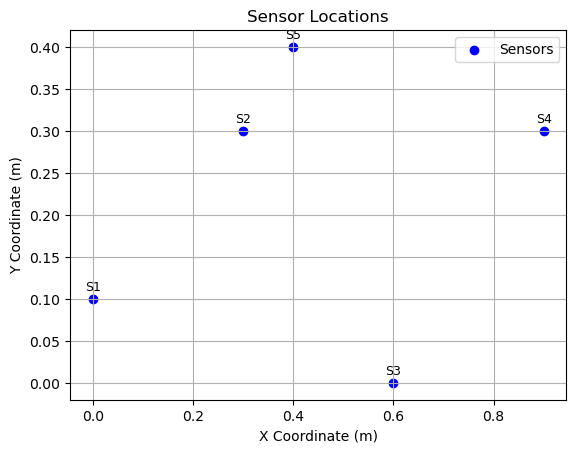

In [11]:
import matplotlib.pyplot as plt

# Visualize sensor positions
plt.scatter(sensor_locations[:, 0], sensor_locations[:, 1], c='blue', label='Sensors')
for i, (x, y) in enumerate(sensor_locations):
    plt.text(x, y + 0.01, f"S{i+1}", fontsize=9, ha='center')
plt.xlabel('X Coordinate (m)')
plt.ylabel('Y Coordinate (m)')
plt.title('Sensor Locations')
plt.grid()
plt.legend()
plt.show()

Here we essentially randomly calculate the distance between the two sensors, determine what the toa should be
for that distance, then compare that to what it actually is and try to minize that loss.

In [13]:
from scipy.optimize import minimize

# Define the loss function
def loss_function(estimated_locations_flat, noisy_toa, speed):
    num_sensors = noisy_toa.shape[0]
    estimated_locations = estimated_locations_flat.reshape((num_sensors, 2))
    loss = 0
    for i in range(num_sensors):
        for j in range(num_sensors):
            if i != j:
                distance = np.linalg.norm(estimated_locations[i] - estimated_locations[j])
                predicted_toa = distance / speed
                loss += (predicted_toa - noisy_toa[i, j]) ** 2
    return loss

## This loss function is essentially the model.

Next we will actually start to from our initial guess, and try to minmimize the loss function.

In [15]:
## Essentially we randomly choose the the position from the line 
initial_guess = np.random.rand(len(sensor_locations) * 2) * pipe_length

# Opitimze
result = minimize(loss_function, initial_guess, args=(noisy_toa_matrix, speed_of_sound), method='BFGS')
# This BFGS method is an iterative method for solving non-linear optimization problems, essentially like
# the Newton's methods, but we don't require matrix inversion, so its complexity is only O(n^2) instead 
# of the O(n³) requied by Newton's method


estimated_locations = result.x.reshape((len(sensor_locations), 2))

print("True Sensor Locations:")
print(sensor_locations)
print("Estimated Sensor Locations:")
print(estimated_locations)

True Sensor Locations:
[[0.  0.1]
 [0.3 0.3]
 [0.6 0. ]
 [0.9 0.3]
 [0.4 0.4]]
Estimated Sensor Locations:
[[0.50156532 0.68983131]
 [0.50038552 0.59033638]
 [0.72290466 0.98148706]
 [0.96626211 0.76640529]
 [0.24865094 0.00289099]]


Immediately we do see that the values are quite far away from each other, this will be even more evident when we plot it below:

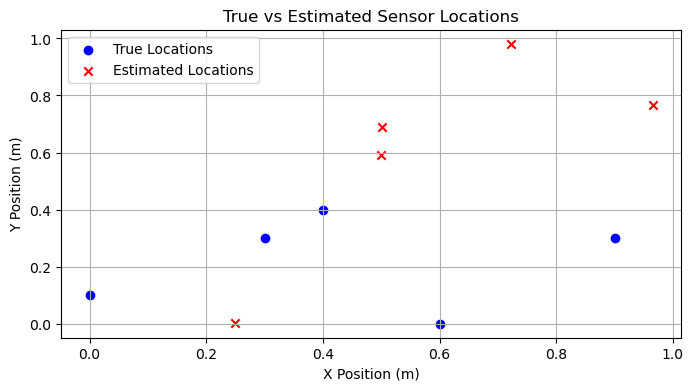

In [17]:
plt.figure(figsize=(8, 4))
plt.scatter(sensor_locations[:, 0], sensor_locations[:, 1], c='blue', label='True Locations')
plt.scatter(estimated_locations[:, 0], estimated_locations[:, 1], c='red', marker='x', label='Estimated Locations')
plt.title("True vs Estimated Sensor Locations")
plt.xlabel("X Position (m)")
plt.ylabel("Y Position (m)")
plt.legend()
plt.grid(True)
plt.show()

It looks better than a random prediction, but not satisfying at all. One possibility is that our random initial guess might
start too far from the original solution, and in actual experiment we might have some knowledge over the actual position. However,
something that is clearly highlighted is the fact that the estimated locations are outside the pipe dimensions. Next we will try to avoid that at least by penalizing the locations outside of the pipe. Instead of using compuationally efiicient 'BFSG' method we will use the differntial_evolution which will find the global minimum.

In [19]:
from scipy.optimize import differential_evolution

def regularized_loss_function(estimated_locations_flat, noisy_toa, speed, pipe_length, pipe_diameter, lambda_reg=1e-3):
    num_sensors = noisy_toa.shape[0]
    estimated_locations = estimated_locations_flat.reshape((num_sensors, 2))
    loss = 0
    # TOA loss
    for i in range(num_sensors):
        for j in range(num_sensors):
            if i != j:
                distance = np.linalg.norm(estimated_locations[i] - estimated_locations[j])
                predicted_toa = distance / speed
                loss += (predicted_toa - noisy_toa[i, j]) ** 2
    # Regularization term: penalize locations outside the pipe
    for loc in estimated_locations:
        loss += lambda_reg * (max(0, -loc[0]) + max(0, loc[0] - pipe_length) +
                              max(0, -loc[1]) + max(0, loc[1] - pipe_diameter))
    return loss

bounds = [(0, pipe_length)] * (num_sensors * 2)  # Bounds for each sensor's x and y coordinates
result_de = differential_evolution(regularized_loss_function, bounds, args=(noisy_toa_matrix, speed_of_sound, pipe_length, pipe_diameter), strategy='best1bin', maxiter=1000, popsize=20)

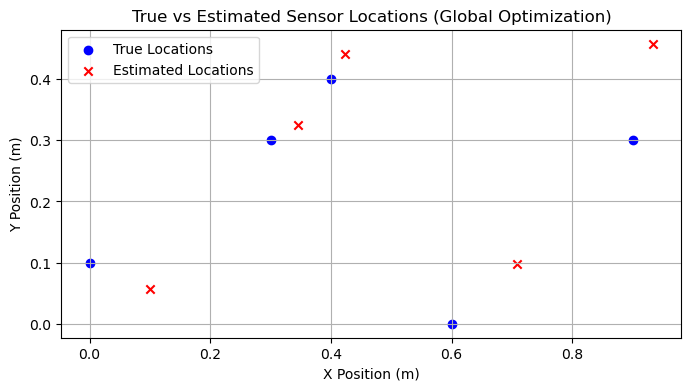

In [20]:

best_estimated_locations = result_de.x.reshape((len(sensor_locations), 2))

# Plot true and estimated sensor locations
plt.figure(figsize=(8, 4))
plt.scatter(sensor_locations[:, 0], sensor_locations[:, 1], c='blue', label='True Locations')
plt.scatter(best_estimated_locations[:, 0], best_estimated_locations[:, 1], c='red', marker='x', label='Estimated Locations')
plt.title("True vs Estimated Sensor Locations (Global Optimization)")
plt.xlabel("X Position (m)")
plt.ylabel("Y Position (m)")
plt.legend()
plt.grid(True)
plt.show()